In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
filename = 'USvideos.csv'
data = pd.read_csv(filename)

## Cleaning the Data

### 1. Removing the Thumbnail Link

I chose to simplify the process of embedding the data by removing the thumbnail link. In reality, the thumbnail to a YouTube video is very important to the success of the video, however because the bulk of my embedding focuses on NLP, I did not want to convolute this process by also learning to embed information contained in images. However, this topic has been explored in other studies: https://towardsdatascience.com/youtube-views-predictor-9ec573090acb.

### 2. Reformatting of Dates

In the original format of the data, the dates were given in a format that included the date and the time, however one of the things which likely contributes to the initial popularity of a video is the day of the week of it's uploaded. To make this more explicit, I added a column specifying the day of the week the date specifies with 0 representing Sunday and 6 representing Saturday

### 3. Removing the Video ID

The video ID is just a hashed UUID for each YouTube video and because itcontributes nothing to a video's popularity. Because the field is also non-numeric, it will cause issues when we apply dimensionality reduction, so I dropped this column as well.

### 4. Removing rows with NaN values

### 5. Removing Columns with Selection Bias

Because the purpose of this model is to predict the success of a new YouTube video, we cannot include attributes that are only populated *after* a video is viewed. Such columns include likes, dislikes, and comment_count, so I remove these to avoid confirmation bias.



In [2]:
# Remove the thumnail_link column, the videoId column and drop NaN values from the dataframe
data.dropna(how = 'any', inplace = True)
data.reset_index(drop = True, inplace = True)
data = data.drop('thumbnail_link', axis = 1)
data = data.drop('video_id', axis =1)

#Experimental below
data = data.drop('likes', axis = 1)
data = data.drop('dislikes', axis = 1)
data = data.drop('comment_count', axis = 1)
data = data.drop('views', axis = 1)

In [3]:
# Reformatting of dates
import datetime
trendingDateIndex = data.columns.get_loc('trending_date')
publishTimeIndex = data.columns.get_loc('publish_time')
data.insert(trendingDateIndex, "trending_month", False)
data.insert(trendingDateIndex + 1, "trending_day", False)
data.insert(trendingDateIndex + 2, "trending_year", False)
data.insert(trendingDateIndex + 3, "trending_dow", False)
data.insert(publishTimeIndex, "publish_month", False)
data.insert(publishTimeIndex + 1, "publish_day", False)
data.insert(publishTimeIndex + 2, "publish_year", False)
data.insert(publishTimeIndex + 3, "publish_dow", False)
data.insert(publishTimeIndex + 4, "publish_time_since_midnight", False)

for i, date in enumerate(data['trending_date']):
    #date format YY.DD.MM
    datefields = date.split('.')
    month = int(datefields[2])
    day = int(datefields[1])
    year = int("20{}".format(datefields[0]))
    data.loc[i, 'trending_month'] = month
    data.loc[i, 'trending_day'] = day
    data.loc[i, 'trending_year'] = year
    data.loc[i, 'trending_dow'] = datetime.date(year, month, day).weekday()
    
data = data.drop('trending_date', axis = 1)
    
failed = 0
for i in range(len(data['publish_time'])):
    #date format YYYY-MM-DD
    #time format HH:MM:SS
    date = data['publish_time'][i]
    portions = date.split('T')
    datefields = portions[0].split('-')
    timefields = portions[1].split('.')[0].split(':')

    day = int(datefields[2])
    month = int(datefields[1])
    year = int(datefields[0])
    data.loc[i, 'publish_month'] = month
    data.loc[i, 'publish_day'] = day
    data.loc[i, 'publish_year'] = year
    data.loc[i, 'publish_dow'] = datetime.date(year, month, day).weekday()
    data.loc[i, 'publish_time_since_midnight'] = int(timefields[0]) * 60 * 60 + int(timefields[1]) * 60 + int(timefields[2])

data = data.drop('publish_time', axis = 1)
data.rename(columns={"publish_time_since_midnight": "publish_time"})
data.to_csv('cleanedUSvideos.csv')


## Embedding Relevant Strings

### 1. Video Description
      This field, with regards to trending videos simultaneously offers very little, and at the same time very much. When people are deciding which video to watch, there is no way to read a description without watching a video, so in some sense this field will not be used by someone when they are deciding what to watch. However the description most richly describes the contents of the video, so it is the closest thing to a "genre" or "classification" which we will get for this dataset. Because of this, it was important to me that the context of the words was captured and used as opposed to a simple average word embedding. Because of this, I used a doc2vec embedding system through the ['gensim'](https://radimrehurek.com/gensim/models/doc2vec.html) library to encode each description into a 50 dimensional vector. Moreover, I trained the model on each of the descriptions with a distributed memory mode of operations as opposed to a distributed bag of words mode of operation in order to preserve information about the ordering of words.
    
### 2. Tags
    This field is used by YouTube to suggest related videos to users and is essentially just a bag of words to which the content of the video relates to. As such, I decided to use the same doc2vec model as above, however this time I trained it to encode the tokens of the tags of each video as a bag of words. 
    
### 3. Title
    Because the title is the field with which the users of YouTube interact, this field is probably the most important. Even though titles are generally pretty short, I still decided to embed this field using doc2vec, but I used the distributed memory mode of operation to preserve the ordering of words since the order could drastically change the meaning of the title. In reality, bag of words models actually perform well with short phrases, especially if one uses n-grams, but to be safe I decided just to use the distributed memory mode.

### 4. Channel Title
    The channel title I was not sure what to do with because a lot of times the channel title is just someone's username which might as well be a meaningless string of letters. At first I thought about just tossing it out in step 1, but I decided not to for two reasons. For one, there are several videos on this list that come from the same channel. Most of the time when this happen, it is from a big channel with a large subscriber base that is notified when a new video is posted which leads to a large number of views. Secondly, there can be channels that may be similarly named or whose names may imply a similar time of posted content. Therefore, I included it, but it may not be very relevant.
 


In [4]:
import gensim

def read_corpus(data, tokens_only = False):
    for i, line in enumerate(data):
        tokens = gensim.utils.simple_preprocess(line)
        if tokens_only:
            yield tokens
        else:
            yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

In [5]:
def generateModel(data, dm = True):
    newModel = gensim.models.doc2vec.Doc2Vec(vector_size = 50, min_count = 2, epochs = 40, dm = dm)
    newModel.build_vocab(data)
    newModel.delete_temporary_training_data()
    return newModel

In [6]:
import re
#Create model to embed descriptions
cleanedVocab = []
for word in data['description'].unique():
    if r'\n' in word:
        word = word.replace(r"\n", " ")
    if "'" in word:
        word = word.replace("'", "")
    if ":" in word:
        word = word.replace(":", "")
    if "/" in word:
        word = word.replace("/", "")
    if "." in word:
        word = word.replace(".", "")
    word = re.sub(r'http\S+', '', word)
    cleanedVocab.append(word)
    
descriptionModel = generateModel(list(read_corpus(cleanedVocab)))

In [7]:
#Clean up tag column
def remove_distractors(x):
    if "|" in x:
        x = x.replace("|", "")
    if "'" in x:
        return x.replace("'", "")
    else:
        return x

data['tags'] = data['tags'].apply(remove_distractors)

#Create model to embed tags
tagsModel = generateModel(read_corpus(data['tags'].unique()), dm = False)

In [8]:
#Create model to embed titles
titleModel = generateModel(read_corpus(data['title'].unique()))

In [9]:
#Create model to embed channel titles
channelTitleModel = generateModel(read_corpus(data['channel_title']))

In [10]:
def getVectors(colName, model):
    vectors = []
    for element in data[colName]:
        tokenizedElement = str(element).split(' ')
        vectors.append(model.infer_vector(tokenizedElement))
    return vectors

descriptionVectors = getVectors('description', descriptionModel)
tagsVectors = getVectors('tags', tagsModel)
titleVectors = getVectors('title', titleModel)
channelTitleVectors = getVectors('channel_title', channelTitleModel)

In [11]:
def vectorizeColumn(data, colName, vectors):
    #Insert new vector columns and set their value
    index = data.columns.get_loc(colName)
    for i in range(50):
        vectorArray = np.array(vectors)
        newColName = "{}_{}".format(colName, i)
        data.insert(i + index, newColName, False)
        data[newColName] = vectorArray[:,i]
    #Drop old column
    data.drop(colName, axis = 1, inplace=True)

vectorizeColumn(data, 'description', descriptionVectors)
vectorizeColumn(data, 'title', titleVectors)
vectorizeColumn(data, 'channel_title', channelTitleVectors)
vectorizeColumn(data, 'tags', tagsVectors)

In [12]:
data.to_csv('embeddedUSvideos.csv', index=False)

In [13]:
def cosineSimilarity(index1, index2):
    return np.dot(descriptionVectors[index1], descriptionVectors[index2]) / (np.linalg.norm(descriptionVectors[index1]) * np.linalg.norm(descriptionVectors[index2]))

In [14]:
#Free up resources
del data

## Begin Experiments

In [15]:
#Set graph options for all experiments
import seaborn as sns
sns.set(font='Franklin Gothic Book',
        rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'lightgrey',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'axes.labelcolor': 'white',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'axes.facecolor': 'dimgrey',
 'figure.facecolor': 'dimgrey',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'white',
 'xtick.bottom': False,
 'xtick.color': 'white',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'white',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})
sns.set_context("notebook", rc={"font.size":16,
                                "axes.titlesize":20,
                                "axes.labelsize":18})

In [17]:
#Define a function for testing
def tenFoldCV(labels, embeddedData, k):
    
    def createSamples():
        shuffledData = pd.DataFrame(embeddedData).sample(random_state=69, frac=1)
        shuffledLabels = pd.DataFrame(labels).sample(random_state=69, frac = 1)
        assert(len(shuffledData) == len(shuffledLabels))
        labelFolds = []
        folds = []
        binSize = int(len(shuffledData) / 10)
        for i in range(10):
            folds.append(shuffledData[i * binSize: i * binSize + binSize])
            labelFolds.append(shuffledLabels[i * binSize: i * binSize + binSize])
        return folds, labelFolds

    def getAccuracy(predictedLabels, trueLabels):
        correct = 0
        for i in range(len(trueLabels)):
            if predictedLabels[i] == trueLabels[i]:
                correct += 1
        return correct / len(trueLabels)

    def evaluateAlgorithm(trainSet, testSet, trueTrLabels, trueTeLabels):
        kmeans = KMeans(n_clusters = k, random_state = 0).fit(trainSet)
        predTrLabels = kmeans.predict(trainSet)
        predTeLabels = kmeans.predict(testSet)
        return getAccuracy(predTrLabels, trueTrLabels), getAccuracy(predTeLabels, trueTeLabels)
    
    samples, sampledLabels = createSamples()
    trAccs = []
    teAccs = []
    for i in range(10):
        testSetCompliment = samples.copy()
        labelSetCompliment = sampledLabels.copy()
        testSetLabels = labelSetCompliment.pop(i).to_numpy().transpose()[0]
        testSet = testSetCompliment.pop(i)
        trainSet = pd.concat(testSetCompliment)
        trainSetLabels = pd.concat(labelSetCompliment).to_numpy().transpose()[0]
        trAcc, teAcc = evaluateAlgorithm(trainSet, testSet, trainSetLabels, testSetLabels)
        trAccs.append(trAcc)
        teAccs.append(teAcc)
    avgTrAcc = sum(trAccs) / len(trAccs)
    avgTeAcc = sum(teAccs) / len(teAccs)
    print("Training Accuracy: {}".format(avgTrAcc))
    print("Testing Accuracy: {}".format(avgTeAcc))
        

### Begin Above/Below Median Views

In [18]:
#Assign labels based on original data
originalData = pd.read_csv('USvideos.csv').dropna().reset_index(drop = True)
medianViews = originalData['views'].quantile(.5)
labels = []
for i in range(len(originalData)):
    numViews = originalData.iloc[i]['views']
    if numViews < medianViews:
        labels.append(0)
    else:
        labels.append(1)
del originalData

In [19]:
#Perform dimensionality reduction and generate model
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

embeddedData = pd.read_csv('embeddedUSvideos.csv')
embeddedData = TSNE(n_components=2).fit_transform(embeddedData)

In [20]:
tenFoldCV(labels, embeddedData ,2)
kmeans = KMeans(n_clusters = 2, random_state = 0).fit(embeddedData)
labeledEmbeddedData = np.column_stack((embeddedData, labels))

Training Accuracy: 0.4983733795722897
Testing Accuracy: 0.49972752043596724


findfont: Font family ['Franklin Gothic Book'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Franklin Gothic Book'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Franklin Gothic Book'] not found. Falling back to DejaVu Sans.


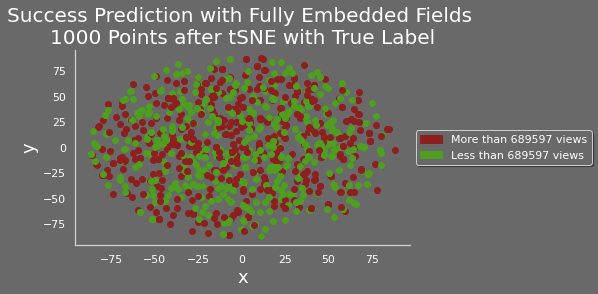

In [21]:
#Plot labeled points in embedded Space
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

numColors = 2
cm = plt.get_cmap('gist_rainbow')

colors = [cm(1.*i/numColors) for i in range(numColors)]

points = np.random.randint(0, len(labeledEmbeddedData), size = 1000)

newPoints = []

for point in points:
    newPoints.append(labeledEmbeddedData[point])

for i, point in enumerate(newPoints):
    if point[2] == 0:
        plt.plot(point[0], point[1], color = '#4e9e1f', marker = 'o')
    elif point[2] == 1:
        plt.plot(point[0], point[1], color = '#8e1f1f', marker = 'o')

plt.title("Success Prediction with Fully Embedded Fields \n1000 Points after tSNE with True Label")
plt.xlabel("x")
plt.ylabel("y")
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
belowMedian = mpatches.Patch(color = '#4e9e1f', label = 'Less than {:.0f} views'.format(medianViews))
aboveMedian = mpatches.Patch(color = '#8e1f1f', label = 'More than {:.0f} views'.format(medianViews))
ax.legend(loc = 'center left', bbox_to_anchor=(1, 0.5), 
          fancybox = True, shadow = True, ncol = 1,
          handles = [aboveMedian, belowMedian])
plt.show()

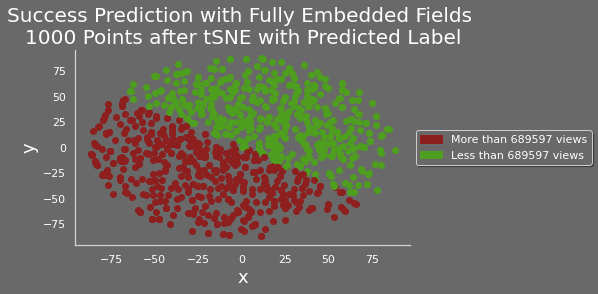

In [22]:
#Plot predicted labels for same points
import matplotlib.pyplot as plt

predictions = kmeans.predict(embeddedData)
for i, point in enumerate(newPoints):
    if predictions[points[i]] == 0:
        plt.plot(point[0], point[1], color = '#4e9e1f', marker = 'o')
    elif predictions[points[i]] == 1:
        plt.plot(point[0], point[1], color = '#8e1f1f', marker = 'o')
        
plt.title("Success Prediction with Fully Embedded Fields \n1000 Points after tSNE with Predicted Label")
plt.xlabel("x")
plt.ylabel("y")
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
belowMedian = mpatches.Patch(color = '#4e9e1f', label = 'Less than {:.0f} views'.format(medianViews))
aboveMedian = mpatches.Patch(color = '#8e1f1f', label = 'More than {:.0f} views'.format(medianViews))
ax.legend(loc = 'center left', bbox_to_anchor=(1, 0.5), 
          fancybox = True, shadow = True, ncol = 1,
          handles = [aboveMedian, belowMedian])
plt.show()

### 99.99 Percentile

In [23]:
#Assign labels based on original data
originalData = pd.read_csv('USvideos.csv').dropna().reset_index(drop = True)
cutoff = originalData['views'].quantile(.9999)
labels = []
aboveCutoff = []
for i in range(len(originalData)):
    numViews = originalData.iloc[i]['views']
    if numViews < cutoff:
        labels.append(0)
    else:
        labels.append(1)
        aboveCutoff.append(i)
        
del originalData

In [24]:
#Perform dimensionality reduction and generate model
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

embeddedData = pd.read_csv('embeddedUSvideos.csv')
embeddedData = TSNE(n_components=2).fit_transform(embeddedData)

In [25]:
tenFoldCV(labels, embeddedData ,2)
kmeans = KMeans(n_clusters = 2, random_state = 0).fit(embeddedData)
labeledEmbeddedData = np.column_stack((embeddedData, labels))

Training Accuracy: 0.5002807365205186
Testing Accuracy: 0.500718355214268


5


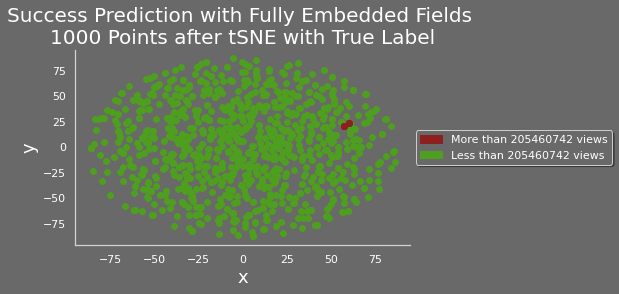

In [26]:
#Plot labeled points in embedded Space
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

numColors = 2
cm = plt.get_cmap('gist_rainbow')

colors = [cm(1.*i/numColors) for i in range(numColors)]

points = np.random.randint(0, len(labeledEmbeddedData), size = 1000)
    
newPoints = []

for point in points:
    newPoints.append((point, labeledEmbeddedData[point]))

for point in aboveCutoff:
    newPoints.append((point, labeledEmbeddedData[point]))
    
print(len(aboveCutoff))
    
for i, point in enumerate(newPoints):
    point = point[1]
    if point[2] == 0:
        plt.plot(point[0], point[1], color = '#4e9e1f', marker = 'o')
    elif point[2] == 1:
        plt.plot(point[0], point[1], color = '#8e1f1f', marker = 'o')

plt.title("Success Prediction with Fully Embedded Fields \n1000 Points after tSNE with True Label")
plt.xlabel("x")
plt.ylabel("y")
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
belowMedian = mpatches.Patch(color = '#4e9e1f', label = 'Less than {:.0f} views'.format(cutoff))
aboveMedian = mpatches.Patch(color = '#8e1f1f', label = 'More than {:.0f} views'.format(cutoff))
ax.legend(loc = 'center left', bbox_to_anchor=(1, 0.5), 
          fancybox = True, shadow = True, ncol = 1,
          handles = [aboveMedian, belowMedian])
plt.show()

(array([0, 1], dtype=int32), array([20575, 19804]))


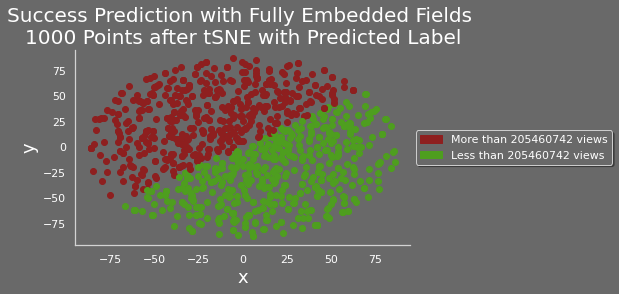

In [27]:
#Plot predicted labels for same points
import matplotlib.pyplot as plt

predictions = kmeans.predict(embeddedData)
print(np.unique(predictions, return_counts=True))
for i, point in enumerate(newPoints):
    idx = point[0]
    point = point[1]
    if predictions[idx] == 0:
        plt.plot(point[0], point[1], color = '#4e9e1f', marker = 'o')
    elif predictions[idx] == 1:
        plt.plot(point[0], point[1], color = '#8e1f1f', marker = 'o')
        
plt.title("Success Prediction with Fully Embedded Fields \n1000 Points after tSNE with Predicted Label")

plt.xlabel("x")
plt.ylabel("y")
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
belowMedian = mpatches.Patch(color = '#4e9e1f', label = 'Less than {:.0f} views'.format(cutoff))
aboveMedian = mpatches.Patch(color = '#8e1f1f', label = 'More than {:.0f} views'.format(cutoff))
ax.legend(loc = 'center left', bbox_to_anchor=(1, 0.5), 
          fancybox = True, shadow = True, ncol = 1,
          handles = [aboveMedian, belowMedian])
plt.show()

### 99.9 Percentile

In [28]:
#Assign labels based on original data
originalData = pd.read_csv('USvideos.csv').dropna().reset_index(drop = True)
cutoff = originalData['views'].quantile(.999)
labels = []
aboveCutoff = []
for i in range(len(originalData)):
    numViews = originalData.iloc[i]['views']
    if numViews < cutoff:
        labels.append(0)
    else:
        labels.append(1)
        aboveCutoff.append(i)
        
del originalData

In [29]:
#Perform dimensionality reduction and generate model
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

embeddedData = pd.read_csv('embeddedUSvideos.csv')
embeddedData = TSNE(n_components=2).fit_transform(embeddedData)

In [30]:
tenFoldCV(labels, embeddedData ,2)
kmeans = KMeans(n_clusters = 2, random_state = 0).fit(embeddedData)
labeledEmbeddedData = np.column_stack((embeddedData, labels))

Training Accuracy: 0.4995678859439078
Testing Accuracy: 0.49398067872182316


41


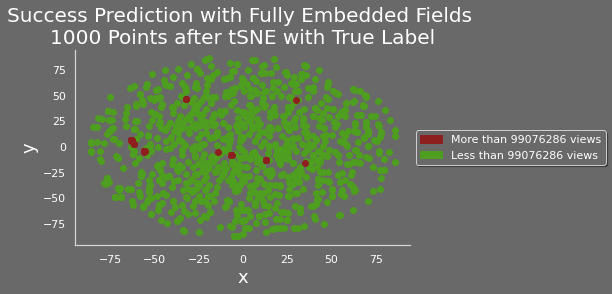

In [31]:
#Plot labeled points in embedded Space
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

numColors = 2
cm = plt.get_cmap('gist_rainbow')

colors = [cm(1.*i/numColors) for i in range(numColors)]

points = np.random.randint(0, len(labeledEmbeddedData), size = 1000)
    
newPoints = []

for point in points:
    newPoints.append((point, labeledEmbeddedData[point]))

for point in aboveCutoff:
    newPoints.append((point, labeledEmbeddedData[point]))
    
print(len(aboveCutoff))
    
for i, point in enumerate(newPoints):
    point = point[1]
    if point[2] == 0:
        plt.plot(point[0], point[1], color = '#4e9e1f', marker = 'o')
    elif point[2] == 1:
        plt.plot(point[0], point[1], color = '#8e1f1f', marker = 'o')

plt.title("Success Prediction with Fully Embedded Fields \n1000 Points after tSNE with True Label")
plt.xlabel("x")
plt.ylabel("y")
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
belowMedian = mpatches.Patch(color = '#4e9e1f', label = 'Less than {:.0f} views'.format(cutoff))
aboveMedian = mpatches.Patch(color = '#8e1f1f', label = 'More than {:.0f} views'.format(cutoff))
ax.legend(loc = 'center left', bbox_to_anchor=(1, 0.5), 
          fancybox = True, shadow = True, ncol = 1,
          handles = [aboveMedian, belowMedian])
plt.show()

(array([0, 1], dtype=int32), array([19922, 20457]))


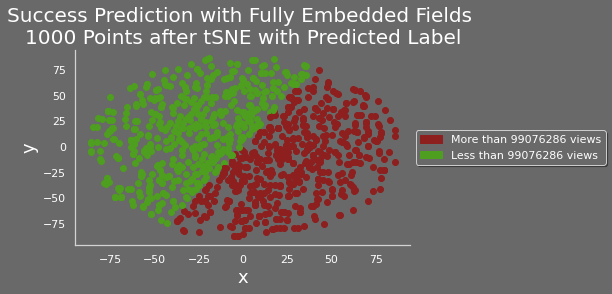

In [32]:
#Plot predicted labels for same points
import matplotlib.pyplot as plt

predictions = kmeans.predict(embeddedData)
print(np.unique(predictions, return_counts=True))
for i, point in enumerate(newPoints):
    idx = point[0]
    point = point[1]
    if predictions[idx] == 0:
        plt.plot(point[0], point[1], color = '#4e9e1f', marker = 'o')
    elif predictions[idx] == 1:
        plt.plot(point[0], point[1], color = '#8e1f1f', marker = 'o')
        
plt.title("Success Prediction with Fully Embedded Fields \n1000 Points after tSNE with Predicted Label")
plt.xlabel("x")
plt.ylabel("y")
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
belowMedian = mpatches.Patch(color = '#4e9e1f', label = 'Less than {:.0f} views'.format(cutoff))
aboveMedian = mpatches.Patch(color = '#8e1f1f', label = 'More than {:.0f} views'.format(cutoff))
ax.legend(loc = 'center left', bbox_to_anchor=(1, 0.5), 
          fancybox = True, shadow = True, ncol = 1,
          handles = [aboveMedian, belowMedian])
plt.show()

### 99 Percentile

In [33]:
#Assign labels based on original data
originalData = pd.read_csv('USvideos.csv').dropna().reset_index(drop = True)
cutoff = originalData['views'].quantile(.99)
labels = []
aboveCutoff = []
for i in range(len(originalData)):
    numViews = originalData.iloc[i]['views']
    if numViews < cutoff:
        labels.append(0)
    else:
        labels.append(1)
        aboveCutoff.append(i)
        
del originalData

In [34]:
#Perform dimensionality reduction and generate model
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

embeddedData = pd.read_csv('embeddedUSvideos.csv')
embeddedData = TSNE(n_components=2).fit_transform(embeddedData)

In [35]:
tenFoldCV(labels, embeddedData ,2)
kmeans = KMeans(n_clusters = 2, random_state = 0).fit(embeddedData)
labeledEmbeddedData = np.column_stack((embeddedData, labels))

Training Accuracy: 0.49796328406682633
Testing Accuracy: 0.4978201634877384


404


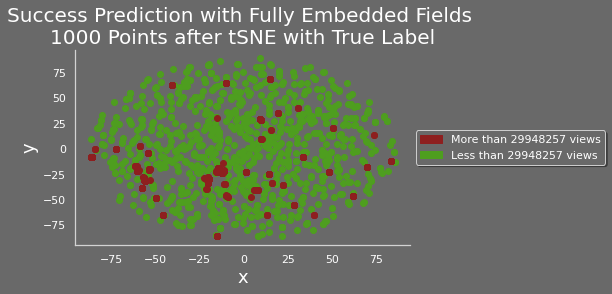

In [36]:
#Plot labeled points in embedded Space
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

numColors = 2
cm = plt.get_cmap('gist_rainbow')

colors = [cm(1.*i/numColors) for i in range(numColors)]

points = np.random.randint(0, len(labeledEmbeddedData), size = 1000)
    
newPoints = []

for point in points:
    newPoints.append((point, labeledEmbeddedData[point]))

for point in aboveCutoff:
    newPoints.append((point, labeledEmbeddedData[point]))
    
print(len(aboveCutoff))
    
for i, point in enumerate(newPoints):
    point = point[1]
    if point[2] == 0:
        plt.plot(point[0], point[1], color = '#4e9e1f', marker = 'o')
    elif point[2] == 1:
        plt.plot(point[0], point[1], color = '#8e1f1f', marker = 'o')

plt.title("Success Prediction with Fully Embedded Fields \n1000 Points after tSNE with True Label")
plt.xlabel("x")
plt.ylabel("y")
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
belowMedian = mpatches.Patch(color = '#4e9e1f', label = 'Less than {:.0f} views'.format(cutoff))
aboveMedian = mpatches.Patch(color = '#8e1f1f', label = 'More than {:.0f} views'.format(cutoff))
ax.legend(loc = 'center left', bbox_to_anchor=(1, 0.5), 
          fancybox = True, shadow = True, ncol = 1,
          handles = [aboveMedian, belowMedian])
plt.show()

(array([0, 1], dtype=int32), array([20247, 20132]))


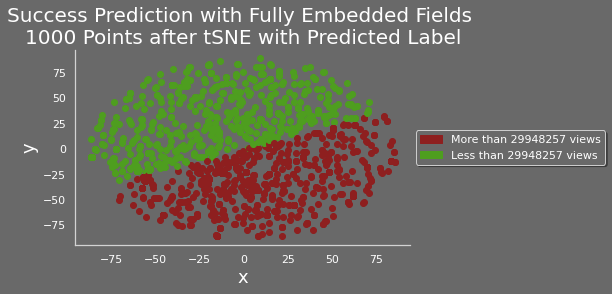

In [37]:
#Plot predicted labels for same points
import matplotlib.pyplot as plt

predictions = kmeans.predict(embeddedData)
print(np.unique(predictions, return_counts=True))
for i, point in enumerate(newPoints):
    idx = point[0]
    point = point[1]
    if predictions[idx] == 0:
        plt.plot(point[0], point[1], color = '#4e9e1f', marker = 'o')
    elif predictions[idx] == 1:
        plt.plot(point[0], point[1], color = '#8e1f1f', marker = 'o')
        
plt.title("Success Prediction with Fully Embedded Fields \n1000 Points after tSNE with Predicted Label")
plt.xlabel("x")
plt.ylabel("y")
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
belowMedian = mpatches.Patch(color = '#4e9e1f', label = 'Less than {:.0f} views'.format(cutoff))
aboveMedian = mpatches.Patch(color = '#8e1f1f', label = 'More than {:.0f} views'.format(cutoff))
ax.legend(loc = 'center left', bbox_to_anchor=(1, 0.5), 
          fancybox = True, shadow = True, ncol = 1,
          handles = [aboveMedian, belowMedian])
plt.show()

### 10 Quantile Bins

In [38]:
#Assign labels based on originalData
originalData = pd.read_csv('USvideos.csv').dropna().reset_index(drop = True)
quantiles = []
numQuantiles = 10
labels =[]
for i in range(numQuantiles):
    quantiles.append(originalData['views'].quantile((1/numQuantiles) * i))
                     
for i in range(len(originalData)):
    numViews = originalData.iloc[i]['views']
    previous = 0
    for j in range(len(quantiles)):
        if numViews >= previous and numViews < quantiles[j]:
            labels.append(j)
            break
        elif j == len(quantiles) - 1 and numViews > quantiles[j]:
            labels.append(j + 1)
        else:
            previous = quantiles[j]

numClusters = len(quantiles)
del originalData

In [39]:
#Perform dimensionality reduction and generate model
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

embeddedData = pd.read_csv('embeddedUSvideos.csv')
embeddedData = TSNE(n_components=2).fit_transform(embeddedData)

In [40]:
tenFoldCV(labels, embeddedData , numQuantiles)
kmeans = KMeans(n_clusters = numQuantiles, random_state = 0).fit(embeddedData)
labeledEmbeddedData = np.column_stack((embeddedData, labels))

Training Accuracy: 0.09225772713511135
Testing Accuracy: 0.09353480307158782


findfont: Font family ['Franklin Gothic Book'] not found. Falling back to DejaVu Sans.


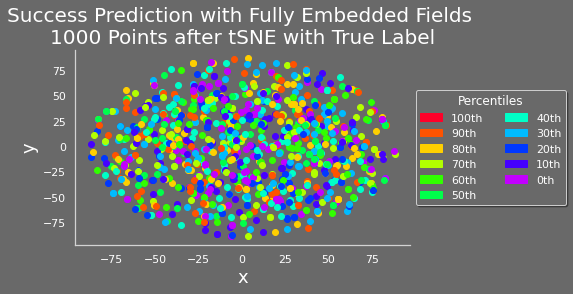

In [41]:
#Plot points in embedded space
import matplotlib.pyplot as plt

numColors = numClusters + 1
cm = plt.get_cmap('gist_rainbow')

colors = [cm(1.*i/numColors) for i in range(numColors)]

points = np.random.randint(0, len(embeddedData), size = 1000)

newPoints = []

for point in points:
    newPoints.append(labeledEmbeddedData[point])

# predictions = kmeans.predict(embeddedData)
for i, point in enumerate(newPoints):
        plt.plot(point[0], point[1], color = colors[int(point[2])], marker = 'o', label = point[2])

plt.title("Success Prediction with Fully Embedded Fields \n1000 Points after tSNE with True Label")
plt.xlabel("x")
plt.ylabel("y")
ax = plt.gca()
box = ax.get_position()
handles = []
for i, color in enumerate(colors):
    handles.append(mpatches.Patch(color = color, label = "{:.0f}th".format((1-(.1*i))*100)))
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
ax.legend(title = "Percentiles", loc = 'center left', bbox_to_anchor=(1, 0.5), 
          fancybox = True, shadow = True, ncol = 2, handles = handles)
plt.show()

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32), array([3609, 3638, 3967, 4655, 4334, 3626, 4917, 3708, 4542, 3383]))


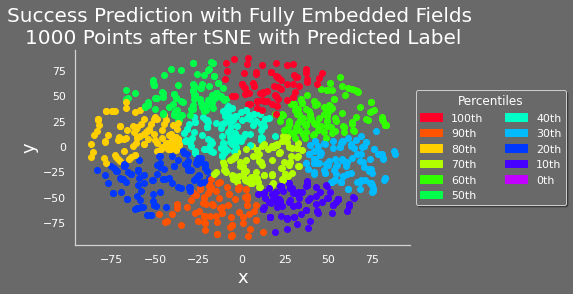

In [42]:
#Plot predicted labels for same points
import matplotlib.pyplot as plt

predictions = kmeans.predict(embeddedData)
print(np.unique(predictions, return_counts=True))
      
for i, point in enumerate(newPoints):
    plt.plot(point[0], point[1], color = colors[int(predictions[points[i]])], marker = 'o')
        
plt.title("Success Prediction with Fully Embedded Fields \n1000 Points after tSNE with Predicted Label")
plt.xlabel("x")
plt.ylabel("y")
ax = plt.gca()
box = ax.get_position()
handles = []
for i, color in enumerate(colors):
    handles.append(mpatches.Patch(color = color, label = "{:.0f}th".format((1-(.1*i))*100)))
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
ax.legend(title = "Percentiles", loc = 'center left', bbox_to_anchor=(1, 0.5), 
          fancybox = True, shadow = True, ncol = 2, handles = handles)
plt.show()

### Labels by category_id with full embedding

In [43]:
#Assign labels based on original data
originalData = pd.read_csv('USvideos.csv').dropna().reset_index(drop = True)
labels = []
labelMap = {}
currLabel = 0
for i in range(len(originalData)):
    catId = originalData.iloc[i]['category_id']
    if catId not in labelMap:
        labelMap[catId] = currLabel
        currLabel += 1
    labels.append(labelMap[catId])
numClusters = len(originalData['category_id'].unique())
del originalData

In [44]:
#Perform dimensionality reduction and generate model
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
embeddedData = pd.read_csv('embeddedUSvideos.csv')
embeddedData = TSNE(n_components=2).fit_transform(embeddedData)

In [45]:
tenFoldCV(labels, embeddedData , numClusters)
kmeans = KMeans(n_clusters = numClusters, random_state = 0).fit(embeddedData)
labeledEmbeddedData = np.column_stack((embeddedData, labels))

Training Accuracy: 0.06524647015110228
Testing Accuracy: 0.06789695318305672


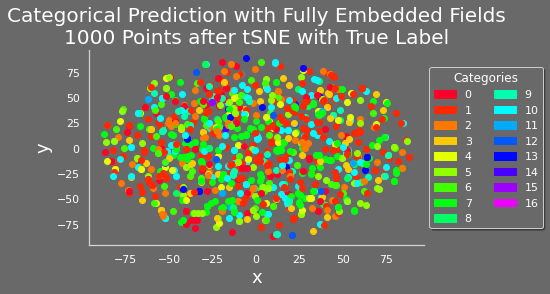

In [46]:
#Plot points in embedded space
import matplotlib.pyplot as plt

numColors = numClusters + 1
cm = plt.get_cmap('gist_rainbow')

colors = [cm(1.*i/numColors) for i in range(numColors)]

points = np.random.randint(0, len(embeddedData), size = 1000)

newPoints = []

for point in points:
    newPoints.append(labeledEmbeddedData[point])

# predictions = kmeans.predict(embeddedData)
for i, point in enumerate(newPoints):
        plt.plot(point[0], point[1], color = colors[int(point[2])], marker = 'o')

plt.title("Categorical Prediction with Fully Embedded Fields\n1000 Points after tSNE with True Label")
plt.xlabel("x")
plt.ylabel("y")
ax = plt.gca()
box = ax.get_position()
handles = []
for i, color in enumerate(colors):
    handles.append(mpatches.Patch(color = color, label = int(i)))
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
ax.legend(title = "Categories", loc = 'center left', bbox_to_anchor=(1, 0.5), 
          fancybox = True, shadow = True, ncol = 2, handles = handles)
plt.show()

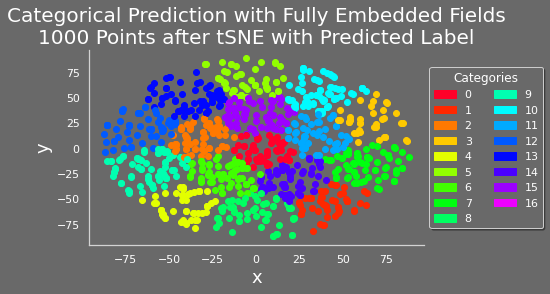

In [47]:
#Plot predicted labels for same points
import matplotlib.pyplot as plt

predictions = kmeans.predict(embeddedData)
for i, point in enumerate(newPoints):
    plt.plot(point[0], point[1], color = colors[int(predictions[points[i]])], marker = 'o')
        
plt.title("Categorical Prediction with Fully Embedded Fields\n1000 Points after tSNE with Predicted Label")
plt.xlabel("x")
plt.ylabel("y")
ax = plt.gca()
box = ax.get_position()
handles = []
for i, color in enumerate(colors):
    handles.append(mpatches.Patch(color = color, label = int(i)))
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
ax.legend(title = "Categories", loc = 'center left', bbox_to_anchor=(1, 0.5), 
          fancybox = True, shadow = True, ncol = 2, handles = handles)
plt.show()

### Labels by category_id with only description fields


In [48]:
#Assign labels based on original data
originalData = pd.read_csv('USvideos.csv').dropna().reset_index(drop = True)
labels = []
labelMap = {}
currLabel = 0
for i in range(len(originalData)):
    catId = originalData.iloc[i]['category_id']
    if catId not in labelMap:
        labelMap[catId] = currLabel
        currLabel += 1
    labels.append(labelMap[catId])
numClusters = len(originalData['category_id'].unique())
del originalData

In [49]:
#Perform dimensionality reduction and generate model
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

#Set up data set to only use description columns
embeddedData = pd.read_csv('embeddedUSvideos.csv')
for column in embeddedData:
    if 'description' not in column:
        embeddedData.drop(column, axis = 1, inplace = True)

embeddedData = TSNE(n_components=2).fit_transform(embeddedData)

In [50]:
tenFoldCV(labels, embeddedData , numClusters)
kmeans = KMeans(n_clusters = numClusters, random_state = 0).fit(embeddedData)
labeledEmbeddedData = np.column_stack((embeddedData, labels))

Training Accuracy: 0.061365700602757825
Testing Accuracy: 0.06123358929898439


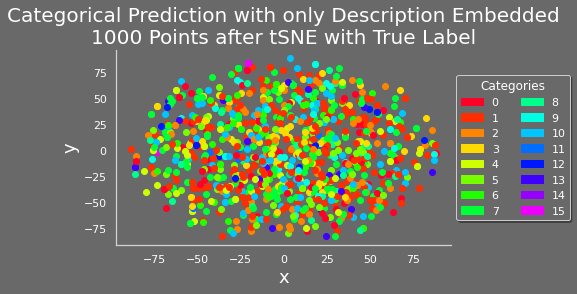

In [51]:
#Plot points in embedded space
import matplotlib.pyplot as plt

numColors = numClusters
cm = plt.get_cmap('gist_rainbow')

colors = [cm(1.*i/numColors) for i in range(numColors)]

points = np.random.randint(0, len(embeddedData), size = 1000)

newPoints = []

for point in points:
    newPoints.append(labeledEmbeddedData[point])

# predictions = kmeans.predict(embeddedData)
for i, point in enumerate(newPoints):
        plt.plot(point[0], point[1], color = colors[int(point[2])], marker = 'o')

plt.title("Categorical Prediction with only Description Embedded\n1000 Points after tSNE with True Label")
plt.xlabel("x")
plt.ylabel("y")
ax = plt.gca()
box = ax.get_position()
handles = []
for i, color in enumerate(colors):
    handles.append(mpatches.Patch(color = color, label = int(i)))
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
ax.legend(title = "Categories", loc = 'center left', bbox_to_anchor=(1, 0.5), 
          fancybox = True, shadow = True, ncol = 2, handles = handles)
plt.show()

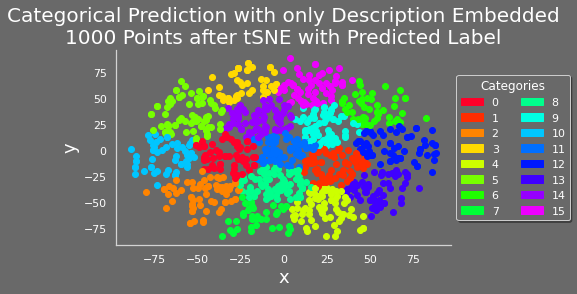

In [52]:
#Plot predicted labels for same points
import matplotlib.pyplot as plt

predictions = kmeans.predict(embeddedData)
for i, point in enumerate(newPoints):
    plt.plot(point[0], point[1], color = colors[int(predictions[points[i]])], marker = 'o')
        
plt.title("Categorical Prediction with only Description Embedded\n1000 Points after tSNE with Predicted Label")
plt.xlabel("x")
plt.ylabel("y")
ax = plt.gca()
box = ax.get_position()
handles = []
for i, color in enumerate(colors):
    handles.append(mpatches.Patch(color = color, label = int(i)))
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
ax.legend(title = "Categories", loc = 'center left', bbox_to_anchor=(1, 0.5), 
          fancybox = True, shadow = True, ncol = 2, handles = handles)
plt.show()

### Labels by category_id with only title fields

In [53]:
#Assign labels based on original data
originalData = pd.read_csv('USvideos.csv').dropna().reset_index(drop = True)
labels = []
labelMap = {}
currLabel = 0
for i in range(len(originalData)):
    catId = originalData.iloc[i]['category_id']
    if catId not in labelMap:
        labelMap[catId] = currLabel
        currLabel += 1
    labels.append(labelMap[catId])
numClusters = len(originalData['category_id'].unique())
del originalData

In [54]:
#Perform dimensionality reduction and generate model
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

#Set up data set to only use description columns
embeddedData = pd.read_csv('embeddedUSvideos.csv')
for column in embeddedData:
    if 'title' not in column or 'channel' in column:
        embeddedData.drop(column, axis = 1, inplace = True)

embeddedData = TSNE(n_components=2).fit_transform(embeddedData)

In [55]:
tenFoldCV(labels, embeddedData , numClusters)
kmeans = KMeans(n_clusters = numClusters, random_state = 0).fit(embeddedData)
labeledEmbeddedData = np.column_stack((embeddedData, labels))

Training Accuracy: 0.06263451958274847
Testing Accuracy: 0.06160515234084716


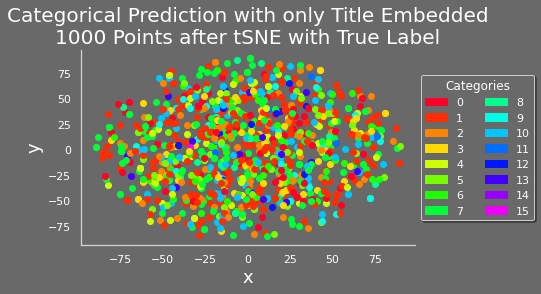

In [56]:
#Plot points in embedded space
import matplotlib.pyplot as plt

numColors = numClusters
cm = plt.get_cmap('gist_rainbow')

colors = [cm(1.*i/numColors) for i in range(numColors)]

points = np.random.randint(0, len(embeddedData), size = 1000)

newPoints = []

for point in points:
    newPoints.append(labeledEmbeddedData[point])

# predictions = kmeans.predict(embeddedData)
for i, point in enumerate(newPoints):
        plt.plot(point[0], point[1], color = colors[int(point[2])], marker = 'o')

plt.title("Categorical Prediction with only Title Embedded\n1000 Points after tSNE with True Label")
plt.xlabel("x")
plt.ylabel("y")
ax = plt.gca()
box = ax.get_position()
handles = []
for i, color in enumerate(colors):
    handles.append(mpatches.Patch(color = color, label = int(i)))
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
ax.legend(title = "Categories", loc = 'center left', bbox_to_anchor=(1, 0.5), 
          fancybox = True, shadow = True, ncol = 2, handles = handles)
plt.show()

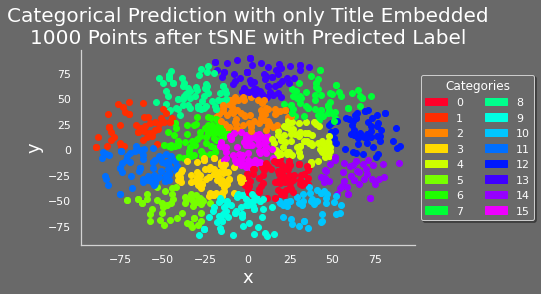

In [57]:
#Plot predicted labels for same points
import matplotlib.pyplot as plt

predictions = kmeans.predict(embeddedData)
for i, point in enumerate(newPoints):
    plt.plot(point[0], point[1], color = colors[int(predictions[points[i]])], marker = 'o')
        
plt.title("Categorical Prediction with only Title Embedded\n1000 Points after tSNE with Predicted Label")
plt.xlabel("x")
plt.ylabel("y")
ax = plt.gca()
box = ax.get_position()
handles = []
for i, color in enumerate(colors):
    handles.append(mpatches.Patch(color = color, label = int(i)))
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
ax.legend(title = "Categories", loc = 'center left', bbox_to_anchor=(1, 0.5), 
          fancybox = True, shadow = True, ncol = 2, handles = handles)
plt.show()

### Labels by category_id with only tags fields

In [58]:
#Assign labels based on original data
originalData = pd.read_csv('USvideos.csv').dropna().reset_index(drop = True)
labels = []
labelMap = {}
currLabel = 0
for i in range(len(originalData)):
    catId = originalData.iloc[i]['category_id']
    if catId not in labelMap:
        labelMap[catId] = currLabel
        currLabel += 1
    labels.append(labelMap[catId])
numClusters = len(originalData['category_id'].unique())
del originalData

In [59]:
#Perform dimensionality reduction and generate model
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

#Set up data set to only use description columns
embeddedData = pd.read_csv('embeddedUSvideos.csv')
for column in embeddedData:
    if 'tags' not in column:
        embeddedData.drop(column, axis = 1, inplace = True)

embeddedData = TSNE(n_components=2).fit_transform(embeddedData)

In [60]:
tenFoldCV(labels, embeddedData , numClusters)
kmeans = KMeans(n_clusters = numClusters, random_state = 0).fit(embeddedData)
labeledEmbeddedData = np.column_stack((embeddedData, labels))

Training Accuracy: 0.06297580711749648
Testing Accuracy: 0.059375774089670555


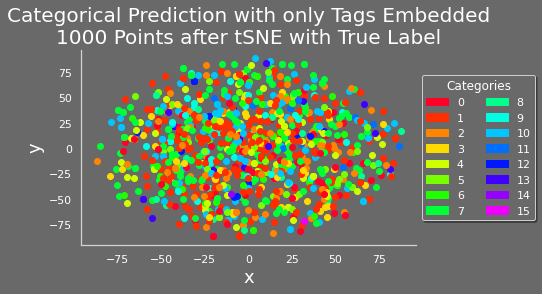

In [61]:
#Plot points in embedded space
import matplotlib.pyplot as plt

numColors = numClusters
cm = plt.get_cmap('gist_rainbow')

colors = [cm(1.*i/numColors) for i in range(numColors)]

points = np.random.randint(0, len(embeddedData), size = 1000)

newPoints = []

for point in points:
    newPoints.append(labeledEmbeddedData[point])

# predictions = kmeans.predict(embeddedData)
for i, point in enumerate(newPoints):
        plt.plot(point[0], point[1], color = colors[int(point[2])], marker = 'o')

plt.title("Categorical Prediction with only Tags Embedded\n1000 Points after tSNE with True Label")
plt.xlabel("x")
plt.ylabel("y")
ax = plt.gca()
box = ax.get_position()
handles = []
for i, color in enumerate(colors):
    handles.append(mpatches.Patch(color = color, label = int(i)))
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
ax.legend(title = "Categories", loc = 'center left', bbox_to_anchor=(1, 0.5), 
          fancybox = True, shadow = True, ncol = 2, handles = handles)
plt.show()

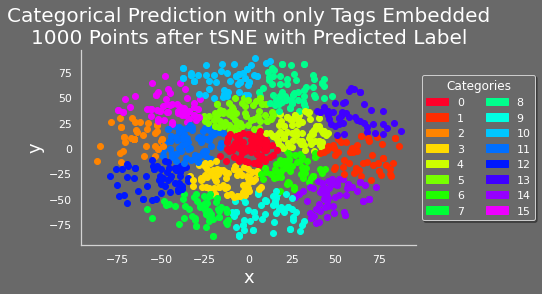

In [62]:
#Plot predicted labels for same points
import matplotlib.pyplot as plt

predictions = kmeans.predict(embeddedData)
for i, point in enumerate(newPoints):
    plt.plot(point[0], point[1], color = colors[int(predictions[points[i]])], marker = 'o')
        
plt.title("Categorical Prediction with only Tags Embedded\n1000 Points after tSNE with Predicted Label")
plt.xlabel("x")
plt.ylabel("y")
ax = plt.gca()
box = ax.get_position()
handles = []
for i, color in enumerate(colors):
    handles.append(mpatches.Patch(color = color, label = int(i)))
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
ax.legend(title = "Categories", loc = 'center left', bbox_to_anchor=(1, 0.5), 
          fancybox = True, shadow = True, ncol = 2, handles = handles)
plt.show()

### Labels by category_id with only channel_title fields

In [63]:
#Assign labels based on original data
originalData = pd.read_csv('USvideos.csv').dropna().reset_index(drop = True)
labels = []
labelMap = {}
currLabel = 0
for i in range(len(originalData)):
    catId = originalData.iloc[i]['category_id']
    if catId not in labelMap:
        labelMap[catId] = currLabel
        currLabel += 1
    labels.append(labelMap[catId])
numClusters = len(originalData['category_id'].unique())
del originalData

In [64]:
#Perform dimensionality reduction and generate model
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

#Set up data set to only use description columns
embeddedData = pd.read_csv('embeddedUSvideos.csv')
for column in embeddedData:
    if 'channel_title' not in column:
        embeddedData.drop(column, axis = 1, inplace = True)
embeddedData = TSNE(n_components=2).fit_transform(embeddedData)

In [65]:
tenFoldCV(labels, embeddedData , numClusters)
kmeans = KMeans(n_clusters = numClusters, random_state = 0).fit(embeddedData)
labeledEmbeddedData = np.column_stack((embeddedData, labels))

Training Accuracy: 0.060845512344149956
Testing Accuracy: 0.06217488233837008


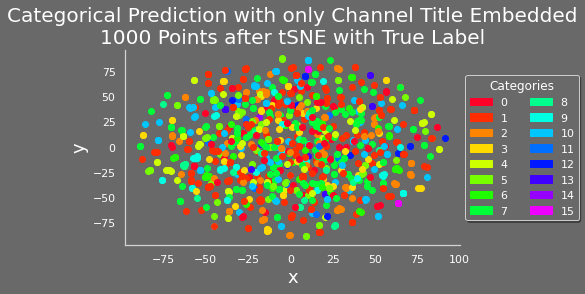

In [66]:
#Plot points in embedded space
import matplotlib.pyplot as plt

numColors = numClusters
cm = plt.get_cmap('gist_rainbow')

colors = [cm(1.*i/numColors) for i in range(numColors)]

points = np.random.randint(0, len(embeddedData), size = 1000)

newPoints = []

for point in points:
    newPoints.append(labeledEmbeddedData[point])

# predictions = kmeans.predict(embeddedData)
for i, point in enumerate(newPoints):
        plt.plot(point[0], point[1], color = colors[int(point[2])], marker = 'o')

plt.title("Categorical Prediction with only Channel Title Embedded\n1000 Points after tSNE with True Label")
plt.xlabel("x")
plt.ylabel("y")
ax = plt.gca()
box = ax.get_position()
handles = []
for i, color in enumerate(colors):
    handles.append(mpatches.Patch(color = color, label = int(i)))
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
ax.legend(title = "Categories", loc = 'center left', bbox_to_anchor=(1, 0.5), 
          fancybox = True, shadow = True, ncol = 2, handles = handles)
plt.show()

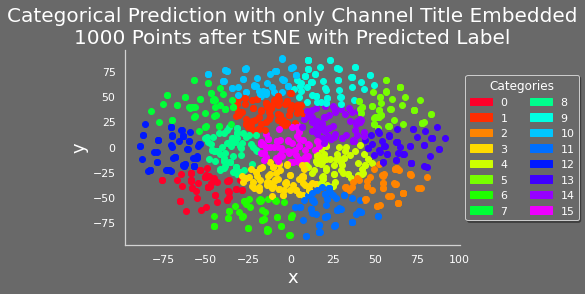

In [67]:
#Plot predicted labels for same points
import matplotlib.pyplot as plt

predictions = kmeans.predict(embeddedData)
for i, point in enumerate(newPoints):
    plt.plot(point[0], point[1], color = colors[int(predictions[points[i]])], marker = 'o')
        
plt.title("Categorical Prediction with only Channel Title Embedded\n1000 Points after tSNE with Predicted Label")
plt.xlabel("x")
plt.ylabel("y")
ax = plt.gca()
box = ax.get_position()
handles = []
for i, color in enumerate(colors):
    handles.append(mpatches.Patch(color = color, label = int(i)))
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
ax.legend(title = "Categories", loc = 'center left', bbox_to_anchor=(1, 0.5), 
          fancybox = True, shadow = True, ncol = 2, handles = handles)
plt.show()